# Analysis


## input data


In [1]:
from auth import sp

def get_all_user_playlists():
    playlists = []
    results = sp.current_user_playlists(limit=50)
    playlists.extend(results['items'])

    while results['next']:
        results = sp.next(results)
        playlists.extend(results['items'])

    return playlists

# Function to handle fetching audio analysis
def get_audio_analysis(track_id):
    try:
        analysis = sp.audio_analysis(track_id)
        
        # Flatten each section with list comprehension and take the first element if available
        bars_info = {f'bar_{k}': v for k, v in analysis['bars'][0].items()} if analysis['bars'] else {}
        beats_info = {f'beat_{k}': v for k, v in analysis['beats'][0].items()} if analysis['beats'] else {}
        sections_info = {f'section_{k}': v for k, v in analysis['sections'][0].items()} if analysis['sections'] else {}
        segments_info = {f'segment_{k}': v for k, v in analysis['segments'][0].items()} if analysis['segments'] else {}
        tatums_info = {f'tatum_{k}': v for k, v in analysis['tatums'][0].items()} if analysis['tatums'] else {}

        # Combine all the flattened sections into a single dictionary
        audio_analysis_info = {**bars_info, **beats_info, **sections_info, **segments_info, **tatums_info}
        
        return audio_analysis_info
    except Exception as e:
        print(f"Error fetching audio analysis for track ID {track_id}: {e}")
        return {}
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [5]:
import pandas as pd
from utils import fetch_all_playlist_tracks

# Get user's playlists
playlists = get_all_user_playlists()
total_playlists = len(playlists)

try:
    existing_tracks_df = pd.read_csv('rated.csv')
    existing_track_ids = existing_tracks_df['id'].tolist()
except FileNotFoundError:
    existing_tracks_df = pd.DataFrame()
    existing_track_ids = []
except:
    print('Error reading existing tracks from CSV.')
    existing_tracks_df = pd.DataFrame()
    existing_track_ids = []
    
# Get the tracks from the playlists in the "Rated" folder
tracks = []
for i, playlist in enumerate(playlists):
    if playlist['name'] in ["0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        playlist_tracks = fetch_all_playlist_tracks(playlist_id)
        track_ids = [item['track']['id'] for item in playlist_tracks]
        
        artist_ids = [[artist['id'] for artist in track['track']['artists']] for track in playlist_tracks]
        
        # Get audio features for each track
        num_tracks_to_fetch = 100  # Maximum number of tracks to fetch at once
        for j in range(0, len(track_ids), num_tracks_to_fetch):
            if track_ids[j] in existing_track_ids:
                audio_features_list = [track for track in existing_tracks_df.to_dict(orient='records') if track['id'] in track_ids[j:j+num_tracks_to_fetch]]
            else:
                audio_features_list = sp.audio_features(track_ids[j:j+num_tracks_to_fetch])
        
        # Fetch artist genres in chunks of 50
        genres_list = []
        for artist_chunk in chunks(artist_ids, 50):
            for c in artist_chunk:
                artists_info = sp.artists(c)
                genres_list.extend([artist['genres'] for artist in artists_info['artists']])
        
        
        for track, audio_features, genres in zip(playlist_tracks[j:j+num_tracks_to_fetch], audio_features_list, genres_list):
            track = track['track']
            track_id = track['id']
            
            audio_analysis = get_audio_analysis(track_id)
            
            # Merge track, its audio features, analysis, and genres
            track.update(audio_features)
            track.update(audio_analysis)
            track['genres'] = genres
        
            # Add rating to track
            track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
            
            
            
            tracks.append(track)
    
df = pd.DataFrame(tracks)

# Add new columns for artist ID and genres
df['artist_id'] = df['artists'].apply(lambda x: x[0]['id'])
df['genres'] = df.apply(lambda x: ', '.join(x['genres']), axis=1)

# Select columns to keep
columns_to_keep = [
    # "album",
    "id",
    "artist_id",
    "genres",
    "duration_ms",
    "explicit",
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    "rating",
]
df = df[columns_to_keep]

# save tracks to csv
print('\nSaving tracks to CSV...')

# try then wait for user input if can't in order for the user to close the file if it's open
try:
    df.to_csv('rated.csv', index=False)
except PermissionError:
    input('Please close the file "rated.csv" then press enter to continue...')
    df.to_csv('rated.csv', index=False)

print(f'Done. Total number of rated songs: {len(tracks)}')


Error reading existing tracks from CSV.
Fetching tracks from '1.0' by Bill
Fetching tracks from '1.5' by Bill
Fetching tracks from '5.0' by Bill
Fetching tracks from '2.5' by Bill
Fetching tracks from '2.0' by Bill
Fetching tracks from '0.5' by Bill
Fetching tracks from '3.0' by Bill
Fetching tracks from '4.5' by Bill
Fetching tracks from '4.0' by Bill
Fetching tracks from '3.5' by Bill
280 / 280 tracks fetched
Saving tracks to CSV...
Done. Total number of rated songs: 308


## output data


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
try:
    tracks_df = pd.read_csv('rated.csv')
except FileNotFoundError:
    print("Error: 'rated.csv' not found.")
    exit()

# Preprocess data
tracks_df = tracks_df.sample(frac=1).reset_index(drop=True)  # Shuffle the data
tracks_df.dropna(inplace=True)  # Drop rows with missing values

# Split the categorical data into separate rows
genres_df = tracks_df['genres'].str.get_dummies(sep=', ')
artists_df = tracks_df['artist_id'].str.get_dummies()

# Drop the original 'genres' and 'artist_id' column and concatenate the one-hot encoded dataframe
tracks_df = pd.concat([tracks_df.drop('genres', axis=1), genres_df], axis=1)
tracks_df = pd.concat([tracks_df.drop('artist_id', axis=1), artists_df], axis=1)

# Normalize numeric columns
numeric_columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'tempo', 'time_signature', 'key']  # Specify your numeric columns
tracks_df[numeric_columns] = (tracks_df[numeric_columns] - tracks_df[numeric_columns].min()) / (tracks_df[numeric_columns].max() - tracks_df[numeric_columns].min())

# Convert boolean columns to int
boolean_columns = [column for column in tracks_df.columns if tracks_df[column].dtype == 'bool']
tracks_df[boolean_columns] = tracks_df[boolean_columns].astype(int)

# Define your target variable
target_column = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into features (X) and target variable (y)
X = tracks_df.drop(target_column, axis=1)
y = tracks_df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()


,id,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,...,7M1FPw29m5FbicYzS2xdpi,7cYEt1pqMgXJdq00hAwVpT,7f5Zgnp2spUuuzKplmRkt7,7gW0r5CkdEUMm42w9XpyZO,7ggrY9cEKx1pnl2lkqx4gu,7kHzfxMLtVHHb523s43rY1,7oht1HPKaMDnuALYWZHgtV,7t0rwkOPGlDPEhaOcVtOt9,7w29UYBi0qsHi5RTcv3lmA,7xkAwz0bQTGDSbkofyQt3U
151,0gEyKnHvgkrkBM6fbeHdwK,0.408196,0,0.929412,0.397355,0.430205,0.636364,0.624943,1,0.0265,...,0,0,0,0,0,0,0,1,0,0
27,0lWjRSzq5chA9fps3pM8Zr,0.281436,1,0.694118,0.378953,0.643623,0.545455,0.843066,1,0.2870,...,0,0,0,0,0,0,0,0,0,0
87,0JIMT9gzLIIz0esKLyjbKf,0.280874,0,0.882353,0.497412,0.443480,0.181818,0.785893,1,0.0274,...,0,0,0,0,0,0,0,0,0,0
157,3zZyFcJZ84mjQWLNrtMr2Z,0.207396,0,0.000000,0.505463,0.400592,0.636364,0.649727,1,0.0377,...,0,0,0,0,0,0,0,0,0,0
70,0hOA8SoraNo2ZP1amtVYnY,0.303979,0,0.647059,0.707878,0.700807,0.909091,0.710774,0,0.0466,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming X and y are your features and target variables as Pandas DataFrames or Series

# Define hyperparameters
n_estimators = 1200
max_depth = 50
min_samples_split = 2
min_samples_leaf = 2

# Initialize the model with the given hyperparameters
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,  min_samples_leaf=min_samples_leaf, random_state=42)

# Define a K-fold cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scores to collect
scores = {
    'MAE': [],
    'MSE': [],
    'R2': []
}

# Perform the k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    predictions = rf.predict(X_test)
    
    # Compute and append scores
    scores['MAE'].append(mean_absolute_error(y_test, predictions))
    scores['MSE'].append(mean_squared_error(y_test, predictions))
    scores['R2'].append(r2_score(y_test, predictions))

# Calculate the mean and standard deviation for each metric
mean_scores = {metric: np.mean(scores[metric]) for metric in scores}
std_scores = {metric: np.std(scores[metric]) for metric in scores}

# Print the results
for metric in mean_scores:
    print(f"{metric}: Mean={mean_scores[metric]}, STD={std_scores[metric]}")


ValueError: could not convert string to float: '0rmGAIH9LNJewFw7nKzZnc'

: 

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, ShuffleSplit
# import numpy as np

# # Assuming X and y are your features and target variables as Pandas DataFrames or Series

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1200],
#     'max_depth': [10, 25, 50, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Initialize the model
# rf = RandomForestRegressor(random_state=42)

# # Define a cross-validator
# cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_search.fit(X, y)

# # Best hyperparameter combination
# print("Best hyperparameters:", grid_search.best_params_)

# # Best model (retrained on the entire dataset using the best hyperparameters)
# best_rf = grid_search.best_estimator_


Fitting 1 folds for each of 108 candidates, totalling 108 fits
Best hyperparameters: {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200}


### analyse feature importance


In [ ]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df[:20]


,Feature,Importance
8,speechiness,0.117663
9,acousticness,0.099656
2,popularity,0.096914
3,danceability,0.076359
0,duration_ms,0.074352
4,energy,0.073346
6,loudness,0.064836
11,liveness,0.057816
13,tempo,0.056837
12,valence,0.048955


## visualisations


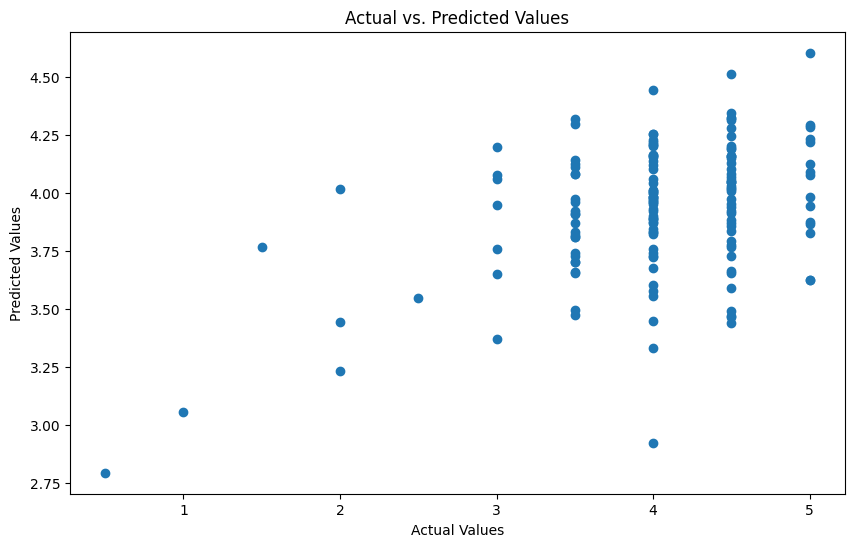

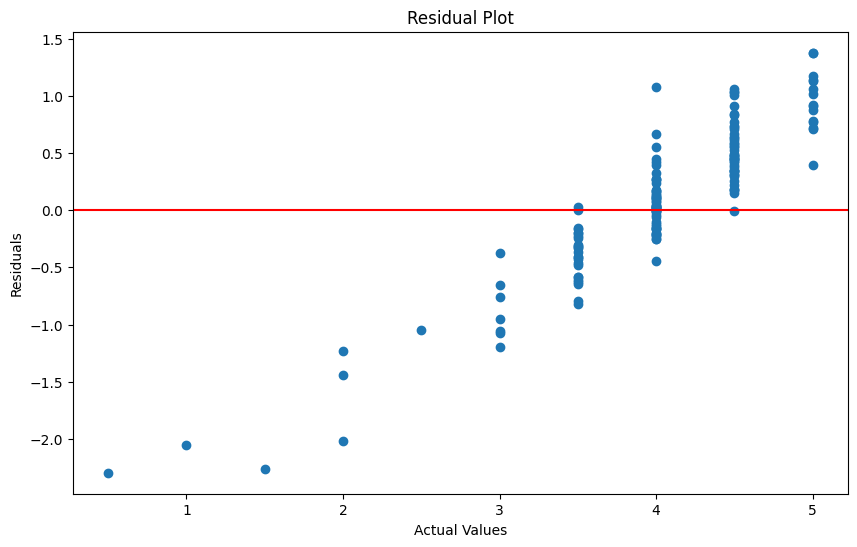

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences


## load unrated songs


In [ ]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
    "0gqrnk12Q8OExuCeKyBRCq",
    "3wXgQJZudZsz7RGyPMTQGa",
    "12TqMgaZKMw6RF39JK6eeF"
]
# discover weekly
# for you.
# release radar
# !!!
# discover weekly (cash)
# discovered weekly (trending.)
# BEST SONGS OF ALL TIME
# best tracks from the top albums of all time - RYM (RateYourMusic)
# 1001 songs you must hear before you die (2017 edition)

In [ ]:
import os
import pandas as pd
from utils import fetch_all_playlist_tracks
from auth import sp

# Load rated songs if exists and ensure it has the correct structure
if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0:
    rated_songs = pd.read_csv('rated.csv')
    # Ensure 'id' column exists, add it if not
    if 'id' not in rated_songs.columns:
        rated_songs['id'] = pd.Series(dtype='str')
else:
    rated_songs = pd.DataFrame(columns=['id'])

# Initialize a set to keep track of unique track IDs, handle empty DataFrame case
unique_track_ids = set(rated_songs['id'].tolist()) if not rated_songs.empty else set()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated.csv') if os.path.exists('unrated.csv') and os.path.getsize('unrated.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    playlist_tracks = fetch_all_playlist_tracks(playlist_id)
    track_ids = [t['track']['id'] for t in playlist_tracks if t['track'] is not None and 'id' in t['track'] and t['track']['id'] not in unique_track_ids]

    # Update the unique_track_ids set
    unique_track_ids.update(track_ids)

    # Get audio features for each track
    for j in range(0, len(track_ids), 100):
        try:
            audio_features_list = sp.audio_features(track_ids[j:j+100])
        except Exception as e:
            print(f"Error fetching audio features: {e}")
            continue
        
        for track, audio_features in zip(playlist_tracks[j:j+100], audio_features_list):
            track = track['track']
            if track is None or 'id' not in track or audio_features is None:
                continue
            
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'] if track['artists'] else 'Unknown',
                'album': track['album']['name'] if 'album' in track else 'Unknown',
                'release_date': track['album']['release_date'] if 'album' in track else 'Unknown',
                'duration_ms': track['duration_ms'],
                'popularity': track['popularity'],
                **{k: v for k, v in audio_features.items() if v is not None}
            })

print(f"\nProcessed {len(tracks)} tracks")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated.csv", index=False)


Fetching tracks from 'Discover Weekly' by Spotify


Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=4JdYapRlYv67LnjrkDhZVX,7vOmSP2647oNUGGEhWd1cr,57wp7VFnV8X0pSVnYArGeJ,3SQ9Hb9rfpJ02AWfaOPhpy,3MtP9T0WF4xbIo8vqHYeXM,1QFh8OH1e78dGd3VyJZCAC,2DrGEaqoruCSn0FffWCf5O,5hTl2uxJGd1sbLtovguuuk,4m2QuDurLmzP9ox7QESPpA,0q21FNwES2bbtcduB6kjEU,7pv80uUHfocFqfTytu1MVi,3KzgdYUlqV6TOG7JCmx2Wg,6Dq2LzijkY9WNPwBGDah4L,6Pgmqg15yVexuOgtzuxwoX,4H4x6mlA3Mk8zUqmLrirGI,0XgRWgcs0Pcr9PSIdFWD4N,6f44p3Kc4ayD9VtbC9Clkr,0eEXcw3JLVXcRxYrVYMy68,70jiETKdlLEram2zJSHdHH,4ZHGRFGwjnEIXHG2FhcDPv,6lAMnXLVCBPMXXWAK4lGSL,54L7uacUGRkvoLokUlNWfH,3FtYbEfBqAlGO46NUDQSAt,6lYY2HktYKpV1pUamfRlU1,2zXkELHmggcgtoHUspOSFC,4vHNeBWDQpVCmGbaccrRzi,0pUVeEgZuNyFzIMKp67RbS,456WNXWhDwYOSf5SpTuqxd,04F42oEuKrRComYJfJuyVR,2uMqG8w8oi09fB2YA2QLOm:
 Max Retries, reason: too many 429 error responses
Fetching tracks from 'for you.' by Spotify


Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=4y5bvROuBDPr5fuwXbIBZR,1dGr1c8CrMLDpV6mPbImSI,3pHkh7d0lzM2AldUtz2x37,1BxfuPKGuaTgP7aM0Bbdwr,1SmiQ65iSAbPto6gPFlBYm,5M1OsXPtMfVM6hbrwIiZnr,2fB5YRuD88drKpCXQOAk03,3Jjwrk3xgnJWPTc48GYhWg,0b7U8X4OjpeJ3HHK7Cw6DN,1rf43cwY7lqr7dqfeM23Jj,4yOp22tLHBjgu866eAwJk8,44rWxt3LrdLf0IclHzQe6v,38dyoMgDMotr4qX8qlL17j,046QZ0ociluzd0yjpY1tY4,5rDVenhWv5PZnVtLGpuyUG,3JoBv1fDAaX2UtvWytvJ4u,1u6O6WXGhuIGjIsvLkNU5A,4HOUg5mmwuAfZBhRVW8YN3,3xKsf9qdS1CyvXSMEid6g8,4yWaGVdcT6VhMyUY7kjV3d,32bkdxME3FzJAxeDOTG8Sg,7KA4W4McWYRpgf0fWsJZWB,0JXXNGljqupsJaZsgSbMZV,3YJJjQPAbDT7mGpX3WtQ9A,0cQVqPuHQP4KEwc7ZUQmj6,7EAMXbLcL0qXmciM5SwMh2,7zFXmv6vqI4qOt4yGf3jYZ,4EWBhKf1fOFnyMtUzACXEc,3GZD6HmiNUhxXYf8Gch723,6oEVnWKgPqIEPc53OYDNqG,2K7xn816oNHJZ0aVqdQsha,6koKhrBBcExADvWuOgceNZ,1ko2lVN0vKGUl9zrU0qSlT,152lZdxL1OR0ZMW6KquMif,0W4NhJhcqKCqEP2GIpDCDq,4kJT7Yj6Za01KfKHjb7mZE,5LrN7yUQAzvthd4QujgPFr,0j3mqDTK4Z6lvrLzFCUUz6,6RiiSy9GzSwiyDEJDiMuKe,7h2nmmoWDi2UpfYKLKWL

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1xttwGi6u3k4FjplxqySDJ,1C0dI2fikcWmnAJ2qik0s2,7nn47VO0UScREyad6hc2DA,5Uu6DwDs2C7pIlSaLL90CA,0ILYxSWnFwD4va8m2yFnsl,4f9wNNZET9wH7eMBgONd3d,2341MWlUctMJQDtYO6Q9b5,2t3VC1SefHeVFB37CIbyQ1,7hdNTegC0TCKKoxB6GTFH3,7gJr3ockQ0fezUXuUXvaSq,0wKxfnayyQ1wa9WExvn4qF,27sKtH0PZpASkN8H3ZJOQf,7lG5m4JN0exualOkghSNXq,0eBAg5wJBu2Acv6o72iY4c,0e8hTieLJC07OakL3BNVJ2,6FqHQ6rP0SCRq52XTNXc3P,6kulrTa9BCDAW5mSi0vynj,49oKnEjgRSs3DMXScEU2G1,2z65iWKbjfz4Ey2URvO1pt,2lZfSMURTqvAChsokZPQZ6,5qxOeTyWa0JAst5fqdrqgu,1RMnWyL9KlDgmAhirqNxin,6Qb7YsAqH4wWFUMbGsCpap,3E2fRdVyqXrb6cMZJGUq3J,0PW454qKfnxKnkVF5pcDLX,0jQonFiP5dkTHCh7jN0r8S,73jxqs3nAUOVNt580QM0g7,3ve72h74iSx1YxO5avj8gN,6n0tjWhWk846PxAAQo9kb7,3d1sRLMVrXnCBawEZo69bR:
 Max Retries, reason: too many 429 error responses
Fetching tracks from '!!!' by Spotify


Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1bjeWoagtHmUKputLVyDxQ,0Z7nGFVCLfixWctgePsRk9,65zIby9Z03d1bhGvLNJNrA,476j7IDRIDRvv1Xu71EVc8,7diD1MucbcRUVjS6AA9ehm,1v4m9GLt7lpFM5iOvwQZrU,3qhlB30KknSejmIvZZLjOD,19quyzgfIQzGM8K71UgMhp,4Fuf1v4kPQ6RIvEGlUfvaq,3h5TiWTqGxjSjFrbruPFH9,5rb9QrpfcKFHM1EUbSIurX,7JgNAnCjJvL8hBR1kmCOFF,6Dk5fHTvH897XrVzCO64Mx,6NMqeF0Ssmi7d3dSUqnOFf,6tNQ70jh4OwmPGpYy6R2o9,7lIyBKp2KX7ABDjDfo9EtL,6uTPdRrEDeH8Fyg5L5qmeU,4tKGFmENO69tZR9ahgZu48,6dpLxbF7lfCAnC9QRTjNLK,4AawZPPdYDoIiYrWU3pgZX,1ACA277B6f46DYCgZW8di3,1iupzLgX4O0Qosb4yDpYoz,3KTRve0Kx6ytMtlEWkWcgt,5ZJGv7aGdIr9IGpxzSG18T,3U5JVgI2x4rDyHGObzJfNf,4HMop4Re0iucehmF7mgV27,5l6hpyTGBK0LAAxgPnqTQL,6usohdchdzW9oML7VC4Uhk,2l7UudWZ44l1WbHx6ANod9,1udwFobQ1JoOdWPQrp2b6u,7gaA3wERFkFkgivjwbSvkG,7hgY5a1FNiChuxoSZDyaMs,7to68V64Cu6zk0UDo5tyw3,52eIcoLUM25zbQupAZYoFh,0nlERwr8m4Ks1RYYuTVm0C,45FCt12lQyBdxUrLtM4Uor,5a8z2vyIDKMh5qcRG6w9wu,4w2Furap0ZzaiK4J14E9sR,4BY4V1T0RJK1HmD2Q0ClyK,0YLhxYUv69go9H8iirbS

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=0vZ97gHhemKm6c64hTfJNA,1YLJVmuzeM2YSUkCCaTNUB,54TaGh2JKs1pO9daXNXI5q,7N3PAbqfTjSEU1edb2tY8j,6QDbGdbJ57Mtkflsg42WV5,3KhF2YiNpJvGpfiCW45R6D,6C4LXC9UFH1IKiHYOp0BiJ,0MsrWnxQZxPAcov7c74sSo,6L89mwZXSOwYl76YXfX13s,1Vchex0xowRj9k59RLvRfo,7fgQxIMO8E0sVRs5g4JFLM,1TfqLAPs4K3s2rJMoCokcS,5jkFvD4UJrmdoezzT1FRoP,1PmXm1881bonBI1AlG5uaH,6R0GRYk2vs2XuBVemYK5YZ,57bgtoPSgt236HzfBOd8kj,2hKdd3qO7cWr2Jo0Bcs0MA,6FXwTBdpv4wD0G0Sz3Wxn4,6S3JlDAGk3uu3NtZbPnuhS,5FEXPoPnzueFJQCPRIrC3c,516V4vS25xnGdVgkBWO6Wf,3f3HHRPF5vAo90GwdpDMaQ,3mZFf3Ru4er3cBfzWq72Ol,1P3eYnB5KiF4S2qZ7iQnOP,50xwQXPtfNZFKFeZ0XePWc,0Bs0hUYxz7REyIHH7tRhL2,4ha9ajL4Kz98uldAfuos6p,6myHmPOnx2gKXHURPajWCH,12Lemsk6c6ohm9afZxYUBz,6ZOBP3NvffbU4SZcrnt1k6,4UXIUeistNzMseqDtgWA6d,42et6fnHCw1HIPSrdPprMl,7oK9VyNzrYvRFo7nQEYkWN,28IEbk5a7twNTbUEvWslUb,2TfSHkHiFO4gRztVIkggkE,3YKptz29AsOlm7WAVnztBh,69YhLz5ooQkgSXRElQbkd6,1ynmMEK1fkyiZ6Z6F3ThEt,1LJyFWwVgM8PrAVpsf8oPl,6dGnYIeXmHdcikdzNNDM

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=7eQUgarLukHLkZaO1mxtab,0OaunKfsxkgBvPv68jBbmm,68y6OIiE1nDdI1MLQdJNh8,0KDaN0HL3TcJVTbXlQCEsS,33iv3wnGMrrDugd7GBso1z,5prTs2HAw2G4idHZyeFp8o,6txWz9UapYHVxEd7dDIHXT,2Pwm2YtneLSWi7vyUpT5fs,77NNZQSqzLNqh2A9JhLRkg,5Muvh0ooAJkSgBylFyI3su,4jDmJ51x1o9NZB5Nxxc7gY,4aVuWgvD0X63hcOCnZtNFA,2EoOZnxNgtmZaD8uUmz2nD,7x8dCjCr0x6x2lXKujYD34,3a1lNhkSLSkpJE4MSHpDu9,6eT7xZZlB2mwyzJ2sUKG6w,0wtHjEAzLYYyGuk2WtpGwS,2KVBpW6RR1rGIpr4jDRotF,3bN4tg6rnNPy9GCkGhym4T,2rgqPSIRAfaO2MGo9smdSX,1k1Bqnv2R0uJXQN4u6LKYt,5nPdMALTEd7HOjn16oNf2X,3pf96IFggfQuT6Gafqx2rt,4SXU3lUZ1eb4JWWbkQw43Y,2QgWuCtBpNIpl5trmKCxRf,6ztstiyZL6FXzh4aG46ZPD,54eZmuggBFJbV7k248bTTt,6iwOCZFBlw3Xjj0fuO3sI6,04XdCMi1WhAjVyRJbAtaq0,7LRMbd3LEoV5wZJvXT1Lwb,4nXkbcTj3nyww1cHkw5RAP,3iJxloILmOu2NIRZ0OGyui,5pTWpY8l7B1XcQnijEFGFj,1YTLK2GZMai3LjDwzDL9OD,3yP0cohcr97BUNJcgvmSVg,46eu3SBuFCXWsPT39Yg3tJ,7pKfPomDEeI4TPT6EOYjn9,2RlgNHKcydI9sayD2Df2xp,5oI1A8G8jH5rxt35dPiHIB,0FeCO85RKW8fDRytwXof

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=0GONea6G2XdnHWjNZd6zt3,6EUumCXY2GwkIKcuVGfJyM,0HEmnAUT8PHznIAAmVXqFJ,2WfaOiMkCvy7F5fcp2zZ8L,5VB2p0S9jlSXEUNT5wckIQ,3MRQ3CSjoiV1HFil8ykM9M,6FBmHx1FuaSnTnnnaThgbF,2JS1iE5A5RHvUPH5Zl9jlF,6QG0wcgoCsa9pqFyTg0rRO,4nuUssdgKFy2QyYHHNkZQW,46RVKt5Edm1zl0rXhPJZxz,0qxYx4F3vm1AOnfux6dDxP,3L7RtEcu1Hw3OXrpnthngx,37Q5anxoGWYdRsyeXkkNoI,0lzpfrTARexLFXEACKSXTh,7aHRctaQ7vjxVTVmY8OhAA,6AJlcxjEO2baFC24GPsJjg,7723JnKU2R15Iv4T7OJrly,5VVwwfK6Cp9IydkhKfJUEq,62LJFaYihsdVrrkgUOJC05,3rOD3MfHaXawznE0vrjM5B,0q4xWbV08szzUpGPhVsrcD,1mCsF9Tw4AkIZOjvZbZZdT,5yEPxDjbbzUzyauGtnmVEC,5xC8uOesnn0udeXAYlAnoY,0fsz7tJ7UKXT9hliLfO7aE,5PntSbMHC1ud6Vvl8x56qd,1t1NX1DJQDcmZA0lvCnFjC,5wj4E6IsrVtn8IBJQOd0Cl,1Cwsd5xI8CajJz795oy4XF,2iSxljzM8Xw9EEIGBRW1CD,7A8oXvjcFnGCmzbswJ0MKu,78JmElAFmrPNhLjovDR9Jm,3dzW0SoVNyJTWWJimX8stj,0ttHpMs250dpFkCYAnuhnE,1w5Mus0YI3V4cfNDANJhrc,38zsOOcu31XbbYj9BIPUF1,6sYZrqTUr5py0ZxLdP3q1t,4HjwGX3pJKJTeOSDpT6GCo,0UAJH0k4k3slcE83a9UG

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=0GO8y8jQk1PkHzS31d699N,4QkvD53COA5qLA7rQ1Pa7D,2u5woInaGB7YASEd1CwGBJ,5XrKrD0AjiZwtkPSRf3NTM,3298yRJKPcCndQdNiTZKIo,35ItUJlMtjOQW3SSiTCrrw,62nQ8UZVqR2RMvkJHkcO2o,3Y8Ff1nH44jFywAtpgmleZ,1qRA5BS78u3gME0loMl9AA,35ieKju5aLWFN5UgfJ27mL,4HbiCvH1R7mVOJ7KY7JQBD,1QbQL5m30YNvukitIqAnFG,2lwwrWVKdf3LR9lbbhnr6R,6eYxmK9fdL4hwLnXG2zY3s,7kjhZR3dESBnn0GoHf3tVI,2Pn1HP6ZTVpBaew1jHcs87,1hGy2eLcmC8eKx7qr1tOqx,7yMiX7n9SBvadzox8T5jzT,0qOkHfSClduvkvGk6fCu8l,1KONmY3enP3r3nIPQidWAy,222TScMmzaZ0IdkvbLoin2,4O4Y5pZNd0kge9aw95OaYC,1pXvZZ7Ubwt4rpDt3JEHdY,3zBhihYUHBmGd2bcQIobrF,29Nv2tMZ6NuVwGpQkgz51x,12OkZyDWNBLUqoReoseGrc,70We9AqHenA4jcmXmKzJnZ,1Y2ExJJ9Dmb9po8K0ybSj3,43M5EZXbN0RhqEyZRoswyI,60PZUWKsJC52uXaPlPcEVf,0uGmhcJP4QQUIpaqKK6ESx,0UmdkPmDWIqzGHnTX1Mogg,7C1j16FmovrwUlkn3X9cP6,2EieK2FUAxikMgLoTSZu51,6jPBjORofYaGFOaqDB4kHa,5lWRaa0fBxDE5yU91npPq7,0EQknhinIfbJ12hwMGjOY5,5BtN3kFKoISSWFpXWz7O4L,0oX75M5oIgft6yF9F8ror7,7dGG7W2p1qUzbf7KwZBA

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=3ssX20QT5c3nA9wk78V1LQ,4IYKjN1DrYzxKXt0umJqsG,5ByAIlEEnxYdvpnezg7HTX,4INDiWSKvqSKDEu7mh8HFz,7N1Vjtzr1lmmCW9iasQ8YO,0shK5iZQppbHPQYiy60xs9,0PV1TFUMTBrDETzW6KQulB,6C7RJEIUDqKkJRZVWdkfkH,78TTtXnFQPzwqlbtbwqN0y,1PS1QMdUqOal0ai3Gt7sDQ,46fk9wjYcPm0sgym2b7EEE,1mFHMzbaECWFaPfoePoEYl,0iOZM63lendWRTTeKhZBSC,1JO1xLtVc8mWhIoE3YaCL0,0GL1ye91pT3nJIQzXwncG2,2aoo2jlRnM3A0NyLQqMN2f,6IHQYCcVjN6byEKKsx5n1K,6aBUnkXuCEQQHAlTokv9or,71dkXboU04Jp5oaqkjK5xd,7oaEjLP2dTJLJsITbAxTOz,2LiWNkeUOAeibGxJKxmjsD,5zhuWncJsBKrQ1HhmAKNAg,3i85UIF4nR7qZXTnEwqdPr,63T7DJ1AFDD6Bn8VzG6JE8,3Zwu2K0Qa5sT6teCCHPShP,0jWgAnTrNZmOGmqgvHhZEm,225xvV8r1yKMHErSWivnow,3RNyGLgSvmVRZ7xKUp8Wgd,2oSpQ7QtIKTNFfA08Cy0ku,3uPfVXcjnpOjyzI3jb3js4,3354J49VpkbZJho7Ztdzpw,66dQdXAbtuPdSasezCQVZE,5FZxsHWIvUsmSK1IAvm2pp,7tFiyTwD0nx5a1eklYtX2J,5WhtlIoxoZrMmuaWWEQhwV,1QEEqeFIZktqIpPI4jSVSF,5RLzsVW6UNiV2YrOlKwzNN,4dVbhS6OiYvFikshyaQaCN,6QewNVIDKdSl8Y3ycuHIei,7i6r9KotUPQg3ozKKgEP

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=3PG9Q89FOydXO8rJesUewH,26OjmNri6c4Qt4GrN7lnw7,2DpJ9T2RVRanZcYFHKOAfA,7ufnFt3fA9Ut2K0DILUZ34,0CBLqGc1esSZ5dM2gOZHsU,4B1BnoMpRbe0ps4Bs8BLk8,6AS6xExH5qqqt6HMViLIdo,41jZtFqmBlC0maxnobrQtv,4jEC6MJj3eQnVly58Xqp8e,7wQB9MXmWvzrieBO481NW3,2hnMS47jN0etwvFPzYk11f,3Cx4yrFaX8CeHwBMReOWXI,4U45aEWtQhrm8A5mxPaFZ7,49MHCPzvMLXhRjDantBMVH,1xOXXYh6lTW8laxlW7JP2J,5wQnmLuC1W7ATsArWACrgW,2A2WpdAeo8hRCGnNwtOJJZ,5AHeCmMYYId8l9JthBzO4O,2olVm1lHicpveMAo4AUDRB,2cFl7utlqyZjCXN1G5nRvA,1lr7QGyV5RohlODzAqnuZA,3pecdrUzTZjaqrw6iCLTvd,5TM2eqdzfWPHklI7YnBmsD,3sks3fxIzjffXVaTC4Dl69,7HRv1sYuwgoea1m0JRvChV,42tBlHWL3VfDkUM2iWcc5p,2X9ELgMIcsXQFjn1iFl06y,1cuYCAodLWgzhwE2KFZ8rC,1CKhx6sSkUxzomXnYZqSMh,7tI8c0zPTCulElXIw9aSbg,5hTpBe8h35rJ67eAWHQsJx,413T0g8pNNXYX6t5RqHvx7,1hRDHWWealh2Pk3fnpIe75,1OmKo4t4Bh95xQI6WGiUR3,4RQgqR09VmHn345vRhKQ6T,7GVUmCP00eSsqc4tzj1sDD,1D23GEeQ32aqLw5ZnY3Ivp,4rgwri7LajWVZvdj2N81SS,6vrUTGn5p8IrfTZ0J6sIVM,2KH16WveTQWT6KOG9Rg6

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=59CLXQLZKxRPzMW8S8Gt9N,7ncH66qOYWLn3Bdw4OjoFi,5cRyBkxNi0EWEY6fZyPWnh,3evG0BIqEFMMP7lVJh1cSf,4aX3n1Pn6jiCbvqBL8eqyP,68BTFws92cRztMS1oQ7Ewj,389QX9Q1eUOEZ19vtzzI9O,0IF7XHfvCoEkabkVvaLvv4,6plT7nFGiXKSBP9HFSI4ef,5iUQMwxUPdJBFeGkePtM66,4z0PnuB07fxtVZZRWsCfxb,4qdgv45EPcQqpQ08tF34f8,2xLMifQCjDGFmkHkpNLD9h,3wGXyJGsCf1myH5MooQIqE,32OkBQinMWqa7ZydEkHqVi,6A9JHl24QJIn4fDBND62Wb,7kv7zBjMtVf0eIJle2VZxn,7hs8hDGgNVaLKypyLK9X4R,7JX9kMnP6WHQSNwkKLsPG9,5XMjXjwCkJVmk0AHm7z8IV,45fiGHezyFQj1FxxlSqELm,6lRkdG1HurVS72F9GoBeWJ,2obblQ6tcePeOEVJV6nEGD,1pmYAWY7Kwaj84U3xZxLML,5fyRqeycMofUoGmDis5Gu6,39GBFwBe4GGk7i3yr3F46P,4iET2VSSZ60K8S77FQRPGS,3ZpiT9OFY8BawTHDTi1Pfz,4GiVcDqNQI0fc0yYuRGH9m,7j31rVgGX9Q2blT92VBEA0,3Mmt6Xk0H6VR92PEp6x3hP,08kO8j1E8V1Nak6vdFzNND,1M34CRvGMjOqWf6hmKWlSG,6iX1f3r7oUJnMbGgQ2gx1j,70pR7ZZ3C5mkLWoWtDhl38,7hy088joIbZmkdampmeL0f,0HOrDVS349XFcpCYsO2hAP,2BlaUfBTbWG50DoZHBD1uV,332rItrahpyeNdn4x2zpyM,1tjK9HhmpEfk0ijyIKso

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=5URfZHMlUWTWxPvvSBWcPk,5bJ1DrEM4hNCafcDd1oxHx,5FuQRkuWNYcc79Uf6dVHQW,7oOOI85fVQvVnK5ynNMdW7,2wK7y55bzry7tUDmDqYaz7,5lA3pwMkBdd24StM90QrNR,3AaiEsiqHO2ylnnOdWninE,10kYRZ5byZgBEcmmQizlzj,1stJclD9IGUbxtUnl8CzG3,276zciJ7Fg7Jk6Ta6QuLkp,2dxjKgT0li4qBI3QwuN9Ih,3Ggg7rOtsEHo4ezvrfPYSD,2SmlWvdYG6FsagxN3FkHMI,1595LW73XBxkRk2ciQOHfr,1AWQoqb9bSvzTjaLralEkT,6lSVidZXCnOnYAWcgIqVDF,3jDdpx9PMlfMBS5tOBHFm9,5bcTCxgc7xVfSaMV3RuVke,5bTysxqGHXdSGiZVgljzCY,1VKPiQJnV15flF5B3zeocD,3bH4HzoZZFq8UpZmI2AMgV,7ef4DlsgrMEH11cDZd32M6,1jJci4qxiYcOHhQR247rEU,1BwhFXqoIsePt21WyWIttb,1t4pPnbkOjzoA5RvsDjvUU,4ByEFOBuLXpCqvO1kw8Wdm,0sKlV58cODrjxGFOyf9IXY,2JoZzpdeP2G6Csfdq5aLXP,1Ue1EeFy3jpKQLTR4HKMYF,2sXp9Qmvc7mRaDBjBgcGGi,6lv5xJNWI2fYwjrPG4KFSe,4keAoywVf4jxRvXU7ON0hV,3FzKPS0oVknVlCW3PhxIHl,5pkd9ib1RgbkAd1R9bIOCa,4p8ZzOdHp58cn6SKdrWKzU,150NSrON3DeZM1aLyz3MoM,3hplBjBmQqR49L8THyjTdb,57460SJgSpCXaRJ9YIYHxy,38wCbVfMreML5ZhF5iQuKA,0bRXwKfigvpKZUurwqAl

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=3bE5slaVEfaDreqARl6k4M,6Yv4NG7FPTOWQmsIFnukmX,6M14BiCN00nOsba4JaYsHW,5CTAcf8aS0a0sIsDwQRF9C,4igIYHF3B5VBxEafHauVo3,4DtB1PJsbl4KAb2rZVNCUL,4Hff1IjRbLGeLgFgxvHflk,2bfGNzdiRa1jXZRdfssSzR,64ARxf9iGgx2mV7Hunp7b6,5GxqKrG0zeKA8uYJMjXwj9,3qdDjz9kOvquEFbvXBYOMQ,5zbkoIgrBO5VjrQIEChlre,0eEgMbSzOHmkOeVuNC3E0k,5kSXu5eO8LknVbP4wuqlSd,3yVQkZeKZWZnu1aObNNvey,6tyMDp7sVCjvKK1uyaOvtQ,4KfSdst7rW39C0sfhArdrz,2LScqpywMqGcnum6nNaxXX,5MMnwYs0hIxkENRsbkWJ2G,4yugZvBYaoREkJKtbG08Qr,0r8H7m8knNVn3iUXwQCnVo,4d6eqRtpDX7tydHJGDZUBQ,0vOkmmJEtjuFZDzrQSFzEE,5lDriBxJd22IhOH9zTcFrV,5Dsp18WXBOCw8Td6bFi8lf,03AhYPRQeOqG2j54Tdg94E,5LGOyqfLK30bXT5Qe7l5GP,4ufsFMT6W3QoWJVdPB4I6z,3QZ7uX97s82HFYSmQUAN1D,2lFlveK1y13WWp3vnQtrr3,07nA7gafu75RjIkAUxtjjr,1gzIbdFnGJ226LTl0Cn2SX,4TIJ7zSBNejpoIPaWpWRKc,26wCH8nlaMzeIWHN0Ezjtv,3mcG2NI5G5vhrQtRda1YnA,1gcESexgftSuLuML57Y69q,7mnGQesk1TzQLzQ9bYWZPR,5UvE5QlINnvEc7aFO14DVL,3TZwjdclvWt7iPJUnMpgcs,4cgodXjv4TfrooNQxvlO

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1w29UTa5uUvIri2tWtZ12Y,6Kp8tQd95YPSrSUTkll2Of,1oTHteQbmJw15rPxPVXUTv,0cfqYhY6B8PbGF9vaVNUeG,5YpZh8wfS4moRBk0ijNcXr,0VAoDsKh7Or84V8xP7p1Fs,27AHAtAirQapVldIm4c9ZX,7hf89cT5FEmLV5E9fjrjG7,4H7WNRErSbONkM06blBoGc,2UciqgwVDwro0fev3MFbxJ,6Ius4TC0L3cN74HT7ENE6e,7yotKA30dwTKNEGomV9ZsI,4irYeuAi87yyGHcI4h9s0x,5XAPpyIoYF3QXP34Hv8Pvx,7wPHEEGn0rWMZEDrDcOaDa,4yORBk6ZyYsJpnJchyZevc,70nmZhHZLNVYWP4NON41Zw,5o7ZDvfOry1MNhNLBOJulo,1ZKueMWFwl6qPxczBLqJII,1jzIJcHCXneHw7ojC6LXiF,46CA1H0T1r7u5lDUtVveAh,1qkPQxOTLFmx3bwUOV8Kzw,3v6SdZsS8zR6Go257tldbB,2JZpS2sOdJy37oBpn1GuPW,75kiQfmmuQwgquZ9RLSvuA,6rqj2zeKhLy3exkuFi6mSz,0NjW4SKY3gbfl2orl1p8hr,60b6B2ULC85t4Y5IjZvP7A,1zsAAnB6dMpGOvXjoYP9Um,0qtK3XwbuG153dmwB8iepL,7s5ML7zaUSxb5UsvsqQTSd,1m4C9zlV89rXTfXStluvec,7sJ7zlySCbRw6OjlLhVQMt,4O9tOyMOq8Oioun2MsULH5,2gZUPNdnz5Y45eiGxpHGSc,22L7bfCiAkJo5xGSQgmiIO,08KMh61hPslT7sEf2tEgtT,3oh6SCCeLuXhFpEyepla6G,2fQrGHiQOvpL9UgPvtYy6G,09IOPhEh1OMe0HD9b36F

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=39VMTN5lZ9x41aySZGTbsJ,4BtGch9Jl7HIehy9dK9UzR,3tjg1LDfTT5DLDl0R4zfSg,5spAjqC772iC2KzDvEkmSr,4JXnZwEWkv29Fc0m5nwkQn,2RUhtNBh43RtSg0WBPPq3m,50xeLNGKmskmYUSINhqvfa,0RGdFCIfn00FCkf1LVmXP3,4ycLiPVzE5KamivXrAzGFG,6x4T3kWUcaZI3BpdOlasxH,6rkV9hz91Rr5iHnMRPZdEQ,1wQixSSWydeLgkebOzu3yt,7hZdzXAe5g7P23RAlnFFaB,5bJklzuYjjPmyoD47151fO,3eV6AfuNv2e29t2M0BuuVh,0fsO8vN1CSYiUo7vcEPI01,5UVHpkmh3Mfcm2N6fIw69f,1YqnIlUV1HerN7I0KJvMzo,5bP2LQEIYiAnFfrIx8XCV4,3naDDvqjwCTy6c1xZ1FV6d,1a9qF8g8cctPiaLfJzxVK7,08Ar75Td2vFXnKv750IAsC,1DxaNpUujd8r0rSiv8uCFA,6m192NGYZHIbO5UBkkM4oN,2bSF5Qs8IQE9RRaZIef7mO,5mUNFqUbA1bY9l1qT9tyHT,5l7tdLI34MnxnNyd2nhNIk,0QLyUmGkzS5BnNjjx8e6QD,72Pf3VRjCGRpnhCthX2oYk,6WnYONkaYOchkMXUz0Eu0W,0F8FJjvopb8WYgRXb5Qb9F,7i8BMZK89QmgxAAkyZ46WF,2QHmGfplU3ypWOGgJM46in,3crKPWQlqtBuLK4LCpRdOK,733fZquJgMXoPvjza0BfQ1,02KXSWEx7BuWZxUuzw6YOw,5Gj2kpzwsqJeCJvOvd0sud,6SxP6QQhVoMVeMu5gtvW8V,0E8q2Fx2XuzXCO2NSAppkR,3IrcvqIf3ZiBhf3xdsct

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=3AhXZa8sUQht0UEdBJgpGc,1VKsbTJ78G5bnfyoPz46LA,6VTbbVjKOC2qWagIDbkJrC,6GLPIERsI3GVegT1EBBrZo,32BTFbqhSvYKftE0e8a8d4,3SUusuA9jH1v6PVwtYMbdv,7hm4HTk9encxT0LYC0J6oI,6B182GP3TvEfmgUoIMVUSJ,18oWEPapjNt32E6sCM6VLb,7lQWRAjyhTpCWFC0jmclT4,0HtuDxkKRBmlCNgFtXSJR7,39ErQSYqHIo3egPF6dm090,6Pq9MmkDQYZiiCDpxnvrf6,7hfRrdFJgFKK3cJ4rmkecE,1MJ5f5EYBC92ADD6xcz7nb,3oEHQmhvFLiE7ZYES0ulzv,1L5tZi0izXsi5Kk5OJf4W0,4z7maGZkAonDlXlwo8q69f,2fS3WRUilBxRoFMk3HVaoW,4tggZyGJMNJMooWuRbvN5q,3QuzslMgjJGsw6wC1E9eRi,2M9ro2krNb7nr7HSprkEgo,4vDBJeeQCbhP9FaPPMsYkY,0YMFcrMtBowDdD5bPz0cgy,3qiyyUfYe7CRYLucrPmulD,0JBvtprXP2Z0LP3jmzA7Xp,0QtnwXDziZN1K55fXuLN6q,0SH3ArZw24kjvalx0HSFBn,2aksifNn5ph8igDOkPBA02,4TsmezEQVSZNNPv5RJ65Ov,1dEy9Pl81QopSxNsPxXQxv,3D9iV6cYkYJRAPFO6DRKIE,0GGxVTb0UwDwdaKNjBdCn3,5HOQNAXcPSwV7Gt8AV8qiP,7obb4s6A7gf0Lc2AGxodMy,5VSCgNlSmTV2Yq5lB40Eaw,07nH4ifBxUB4lZcsf44Brn,7DNy5I3V1hFIJ4G5ObU397,60APt5N2NRaKWf5xzJdzyC,0WKYRFtH6KKbaNWjsxqm

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=7AzFID6u1b3zIWbd9pb8Dk,1BvpeiApX8qhof8Pmi3YlH,4vpeKl0vMGdAXpZiQB2Dtd,6WAerOuiLIApXmGhjMPA65,34miSNKQ0xN7EG8zzzaFzI,1eamsmwcYYhJwTgMFdQ6YN,0QwZfbw26QeUoIy82Z2jYp,1jMaB19DiVR8OihLSuYFOt,1wlKw9NAWVWpx7OIAyg9EA,2RVQIq7bLi4Eu6xHPyQ46t,29SRvYOKbMLOZeOubNGtLb,5UwbnHhjnbinJH8TefuQfN,7BY005dacJkbO6EPiOh2wb,7vJaNv4ItDyYXXCVRJreh6,2ACCqi93Mm4oj9bBNEngCQ,7txxAtOMwLLnQTpKeBL6bp,7vYA9ET5AUqJt5pBbhKmcB,07q0QVgO56EorrSGHC48y3,6KTv0Z8BmVqM7DPxbGzpVC,2jz6rWGqVCYsymwxGoaON4,1brpdmqkx3kSxyqzqXfW7J,1HL3yEnYq8LEyFQ3QegA5V,2FfZg072w8RoxlMOR7M4CT,2BjUvisO4UVAtTHs4lYiqu,65KzDXZm9aQt8sA1k0ZVG3,2nklcPJ3YhYJfC2ibStXz9,1OFKUn2VLafrHj7ybnap0Q,3OltYYcLZUhvho5QoRbUNr,37EJtTS7jT5WUyXGZzrwnI,1FvDJ9KGxcqwv1utyPL3JZ,0WQiDwKJclirSYG9v5tayI,1YrnDTqvcnUKxAIeXyaEmU,2OErSh4oVVAUll0vHxdr6p,6BrMEbPSSj55nQhkgf6DnE,1RSy7B2vfPi84N80QJ6frX,3c06k9x6MHHdPQi3ix68yF,305WCRhhS10XUcH6AEwZk6,7MH7TkjQ4RA1vG454dciw0,4qeebkLFVb8zbNZIwEpqre,72boGlgSwUK01n44O2tO

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=5cFcWAWIcnV38t4YCWQiZZ,0UREO3QWbXJW3gOUXpK1am,5p3JunprHCxClJjOmcLV8G,2hdNya0b6Cc2YJ8IyaQIWp,4IU1RL4BKvFyXtbTwaHAvW,6AplSHtiSr0cqimR27ghdV,26VrotMHCu4m9I1rbHB1GN,4WamMWxFi6ts3xkIhivF5c,4qM461TqtpnP4GLRIXwEnW,0qPeLt28yVM4wScp8qt8xY,1v1PV2wERHiMPesMWX0qmO,4XRkQloZFcRrCONN7ZQ49Y,2BkqVLVtEokchvatg3XULo,00kvKlIvfzQLSi6T2zwXuS,0QX4u1gl2VZ6HKShy7BWEn,7aQjPecQdIuNd1sz3KCDhD,0JgMHia55MBfhfqZIRi3kF,1dv3ePjze9tPq2pk8eWJdR,1zGk1kgAxCpg6PHjGuLe4J,2J9GLqNATExevUPvpLU1Sl,05B7Kc8fvBlX0OWbE6piPZ,74iQ3gahRTOGc19bYadBE3,3SdingSsFcZDZAyvcJbgAw,4RGxUjaCmVtD30pIhtEi7w,5u6y4u5EgDv0peILf60H5t,4YMQXzscifAREG0a7KNGhB,2WoqgtWEBbbBKMDN6Becs7,4ZVZBc5xvMyV3WzWktn8i7,1DKyFVzIh1oa1fFnEmTkIl,4T5SR1krNuVLOnxSjYb8nW,7weLWbJdUz7ZQR4ZJX6l59,3x2bXiU0o4WbsPkawXlfDA,3LQPTJEqOfljGBxmpgUnoC,75wP08AtMfGfjk0nPdvVw3,7Ar4G7Ci11gpt6sfH9Cgz5,4J9qfNgyYFAkUK8oIOohN1,1aDLUzCyYpRXgrjwUWzV2X,6WrnSlcN0dzTO80mVVbBto,2x8evxqUlF0eRabbW2JBJd,0YQXMFYxfHNagYPgQvur

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=6acDlNeA06MCVCzsTVGr9V,5mpLcXEsk3jjzLFGuNKk5I,4KW1lqgSr8TKrvBII0Brf8,5CGS4UovzA7ftCJkLVXQju,19a3JfW8BQwqHWUMbcqSx8,5dANgSy7v091dhiPnEXNrf,2cbic3TiUENlJX91y67ARR,2LthqyP0MLhGUBICwR1535,3rCNmRonlHN1TXQLcG3dSk,7vgTNTaEz3CsBZ1N4YQalM,3s7MCdXyWmwjdcWh7GWXas,722tgOgdIbNe3BEyLnejw4,4cAgkb0ifwn0FSHGXnr4F6,52NmkyHsGsHGb1UX8fTkMg,6vB49BJ70zBpDrrAPwdaB8,5VzeI5JM2y9t21JwrWAnkH,5RjbFGeWVsCpw8EcE8OrvZ,2aHlRZIGUFThu3eQePm6yI,4jQqM4NI79HEcWHUJb8Hvf,6ScJMrlpiLfZUGtWp4QIVt,795LIYKphBOsvyMh5hZaPk,2ovQ5MCx91XVjgVWEPfvks,23SZWX2IaDnxmhFsSLvkG2,7yNK27ZTpHew0c55VvIJgm,3ZXcjz3A5vNsR5dA1e6ITl,4Vqd7MuPVrciqRS3EzhKWb,6JyEh4kl9DLwmSAoNDRn5b,7oHkit3F3vimtsBbnZkU0G,287tdUcso07UAu5jxXB2BQ,679RG1vQ3m1liChyglObX9,1jDit1o3MxkQxFDVNdYX9v,4qikXelSRKvoCqFcHLB2H2,6tByydPskASjm9jTPkNQq0,5rk3EqsP1iHuQn5tkC1Qw0,1L94M3KIu7QluZe63g64rv,5Xak5fmy089t0FYmh3VJiY,3xAka0D8585mDoShALnsd7,5jn6ICg6disx9WmB1q4gfS,25dlB85u7PUsXA7PlMok8L,7LVHVU3tWfcxj5aiPFEW

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=5EugXICXL06waHgP4iTI58,1H5IfYyIIAlgDX8zguUzns,41cpvQ2GyGb2BRdIRSsTqK,31pi9vJJWHZxygk8AoGd0d,6FLqFu1ApSkUddZ9P4H6Io,1dF5Y2dd7Wm4wZKvVjWBpr,1mqytV5qZcmzG6MgvJCpkQ,5bHktj4UtEORf7uNWTtxnA,1WYedq08MjytnpXfoM2dl2,0RpBFgNyH8PkOjhG1melFu,2o7XCPsOg3kmvzyFFAbDFz,5VdZARV82uNjclgnDsVyKK,5xilD5ciilxBybht1YGHkD,1W0OCrMsRP1SLTEdw3JwEz,6HZ67VImxqr8aMBEEhblzf,0yx5Hqp7XOG8diGKYbFdPc,2HsjJJL4DhPCzMlnaGv7ap,66MwdlxiFMZ8TJGLEJnS7x,75hLNJfiXV5k2YGrbGEW51,3skn2lauGk7Dx6bVIt5DVj,4Wvr1YaxNsCujq77dKujys,6l4TNbfPtNAOOlGIfceSaO,0b4mzNWt82CE52JGNyLqOX,4vO9dmzNRqDhFY3jD1a3P7,1JkZg3eMQTmTn93E8Yd3UL,7mzHEzbsl5iOvBRuXwReZU,7LbfuQVct78YoghmoPtsQ8,5ZLzl6T8JwqMTMdoE0nCbU,3x1v32I3SZNvC7q7bDhcGm,1ZhrREyOOeFV6TxDOyiPwu,2wvMC5EyaaYQwBfiwwY2xE,1CS7Sd1u5tWkstBhpssyjP,0SFq19lgG4qbQAZaNZ3xhO,2DNXgvkyv35vTWvdgjs7qn,13HVjjWUZFaWilh2QUJKsP,7lGKEWMXVWWTt3X71Bv44I,22VdIZQfgXJea34mQxlt81,05SBRd4fXgn8FX7bf8BCAE,2nZ33CKRbgpJQJJQKHuGXb,4M88Wd7Aps5LGRWMOC7g

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1DunhgeZSEgWiIYbHqXl0c,0rTV5WefWd1J3OwIheTzxM,7wmYgsLNRB9EpqpvR3hkvN,11bD1JtSjlIgKgZG2134DZ,2AYEOC02WLhUiOoaig2SEH,6eKEJZFWllRX4UALhPU967,0ieQRb0HOzAOycmxanAmVG,1CKm95B5JmaSCnZLquInM4,5i9XNqv8ay4PXRBNxfwdfZ,0FBeVAGy58YREuZK2rpRVm,01w1oN1WO5aOThHnLBN8eS,0GVvRmCoiLkhxJvlZy9bLk,1jOORGv77XNdt9B6lqk5ze,5MZQIjtghyFc4sMVUzD7MD,26zo23frbrONsEJs6m2drZ,0GSCAqCsmp7OVUWwC6sSgT,2f14Vwn28w1soYnolluueL,3dKFxCpVtK3g9KAB8S1FwY,1nLnpLXvl68RZCSjfkyiaa,6K4t31amVTZDgR3sKmwUJJ,6ewQE1dNPv9qqlnB1CxrvM,6vqJW25vQ2X9t5Pn7UZD0v,5uDASfU19gDxSjW8cnCaBp,4dAMdQ6g4kGmnc1MDHsg77,7zBPzAjKAqQpcv8F8GCq5s,2qGgFxiXWplBWJwk4jYFuV,08mG3Y1vljYA6bvDt4Wqkj,5LNiqEqpDc8TuqPy79kDBu,5ihS6UUlyQAfmp48eSkxuQ,3sNVsP50132BTNlImLx70i,7c1Dar0pIAW7w5TzaGjt9t,4dkoqJrP0L8FXftrMZongF,4bN43jYf41eIjJZ3UXQpuA,4IoYz8XqqdowINzfRrFnhi,5dyFRTACKvmwoIg3vFLhxr,3Y9wdXMh6sNt9fUwUqTqb7,5HgE5eXfu0An2moseSM635,1K5AjxsfnJ8iaptRBngN1Y,4fXoeBGrVWfNKpdcmL8tw6,3j3OB5PFy7FewVi8l881

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1SmBRixLyEMeG4EwsxoL7S,1WCIA0j4sJfXAj0y23XbSP,1bSpwPhAxZwlR2enJJsv7U,1choyAOWcbOWJNKnUkpQGs,1fOkmYW3ZFkkjIdOZSf596,1gGsNNUfvVMOv4llVMg8Vg,1gm4Cue3Nrw9Q3ixjPfEYr,1huvTbEYtgltjQRXzrNKGi,1kusepF3AacIEtUTYrw4GV,1kwnxJNVl7cwcU98RvMBaR,1n21ZBt3vM1u4r8vkhlub7,1tqT6DhmsrtQgyCKUwotiw,1xqRfUNinqusubH9EnyQM8,1zwCCOoWdeS3d4ITQe8kWT,21jGcNKet2qwijlDFuPiPb,245Wu7BJnPFXGzA0cb0At5,263aNAQCeFSWipk896byo6,2BOqDYLOJBiMOXShCV1neZ,2BlPpQDClWGXuYttAmQcBY,2CwMxEXxMiLRrKPLjQLmne,2DPYlWl50ydYsnnuryL5aX,2EQWbkcNoKPOXQtJM7nqRV,2Fs18NaCDuluPG1DHGw1XG,2Fw5S2gaOSZzdN5dFoC2dj,2INhKpUdzh7v0j041gZNsz,2KVwlelhxKUy8LVV6JypH3,2LMkwUfqC6S6s6qDVlEuzV,2MAaiV0bbeq4FpSwPe2rR8,2Mb3zpobD0CvJGWv6NpsPy,2Nh2cMryoXl7BrZoIeN2Pr,2P3SLxeQHPqh8qKB6gtJY2,2PWnAe9C52xvJYhBFNuIqm,2PpruBYCo4H7WOBJ7Q2EwM,2R0MySb9tgrWIv2mttYAYR,2RH61BqMEeRjfND7MQBWHU,2STQAr3BRiAeeveJ07gZh7,2SwLswBtbxloI4uMcfkfLf,2TjnCxxQRYn56Ye8gkUKiW,2V65y3PX4DkRhy1djlxd9p,2Yv2mHzr5AQavVdwQjEo

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=4H9fsMhr1wLk3xb2o9BNm7,4JRem7xHp2l0kmUvt9zCKu,4JT6HZ2qEbLKiRm1W5rqHV,4K1DB7EedHPuVnhVrnvf2U,4LLBKnNCrSRrSjSTuiwjE9,4NtUY5IGzHCaqfZemmAu56,4Of7rzpRpV1mWRbhp5rAqG,4SlCb8n5Jw52astU7GWPyV,4TQeNHx85xcP9YRkvJC6K1,4WiGGTl7Kt5vnjQHqwLJy1,4XiGKQqbmnMVxDzUj6j3f2,4bl1HBZliBuYpFZjWgefE4,4brX8MJs5hxErgq48f9REO,4cix9zymmhisLuM56RDcB7,4eP6oyNbAJcViaiHtPsOCh,4gMnvtp0lXJY9GkgPGcELg,4gh0ZnHzaTMT1sDga7Ek0N,4kfavrmsMwzD6QnB3biWgP,4qk2jIJtrItzq1kU60UuZN,4rrbptVnZifk4wC5mvNDPm,4rstj4vgkFq49R2VV0fbxX,4u7hiFNXUeTG3A4dqQrkcd,4z6iezaEzhJiyZdjazGH5z,50jEs9EZZgXJ1oDZVAv7Wp,51rPRW8NjxZoWPPjnRGzHw,53Za5vyGc1x7GxgJVRjRKc,56SkdBKyR2zOkjk6wVFI9s,56t3gitNr5atN5i1FF8r7P,58ge6dfP91o9oXMzq3XkIS,5GUYJTQap5F3RDQiCOJhrS,5H6Jp0syB5yEPk7SWYdlmk,5T4j3Uv33fQO7tsR2lMl4y,5VErNsWF69eD0HiBt2vWcH,5VSAonaAPhhGn0G7hMYwWK,5Wj1rJnCLpMHdLaxsFtJLs,5XSU59wtE5CRCAEyHmmGy4,5bknBRjKJZ643DAN2w8Yoy,5cXg9IQS34FzLVdHhp7hu7,5hVghJ4KaYES3BFUATCYn0,5jhfa76FhqtD3Boij6MA

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=07CyrZF9eVd02zzIse7tZA,07SnYttUopjIFHnc1hZIMc,09ezgACZuwWZt6CtQSSLRG,0CGbof9amBnsNlRhZ8IY2H,0O84vcg38upuklnJxLFUjD,0RgcOUQg4qYAEt9RIdf3oB,0W4Kpfp1w2xkY3PrV714B7,0WKmVAD4VWk5EdTyCFILi4,0Zp5bVRHO3frZY3BrDMAO3,0hbC2CAJidLslKqJ39Lxh4,0rzWENXdfcLTgyt5DByGTy,0uvvqMjv7xjfWtvnR1v20W,10cpQoubCoINVqfFsoJTJW,11607FzqoipskTsXrwEHnJ,16TnJhZYL0sSY3dyIWgBbE,1746Hs7bQJMMYAZvVYM3ig,17yrCsl1Ai6CZLBmGj6d6p,1AJ5F0FMTC3yFU3ocjy1gE,1Y63rJLx2KbigqvlXXwRNX,1gGhqfs2pDTOI30AEXMXrn,1kDkaFlmkdEZiVUogaP9OZ,1oXq63OUf43LDnNPVtfvX8,1rJi8cf8OWsrX4CqBnMSoQ,1v870eS7JuHSeBNBFsVz3b,20OFwXhEXf12DzwXmaV7fj,25SJaCCPiosugnlY53VhRG,26G5nmIx7Yvq79bIIluyZV,299lFlaAsNQdgbIZNPmIA0,2B4Y9u4ERAFiMo13XPJyGP,2Bs1Lw9LX8hBm70t1iGdlh,2JtL0a3NHcGkFQ7kfDLKUT,2NCBjlH7FHEG7hXcnvUaWA,2a8HLMRc6E0AM4xXiQ4wh6,2buuesSQNcXtvL0XBwGav5,2iObjOsy2vpsariW4Y7hQg,2lD6AoA8qf2t4Dkf2TcmNK,2ozTcQyZQmm9tSmc4VZfwU,2qtoRFCOEL1gRn5q9DJC7F,2ugghimAssmeO3YpFIV7mb,33xkqF4gkppg311UoMGg

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=7lSDCrF11sdTVfjbAQVZE8,7lxOjQyVsHQ8toQeT7IgCc,7y9O8sJmuX7DvmyrR7h3PY,7zNOt8sNIYHD3iZYp6irr7,04QTBqa3IA4ZAKEuqRPzEH,0YMzPd9mYx4txOuCnhYUGU,0i19MAZbyn8uTir7FprXId,0rgGwEybYIQvqHf5qEkFOB,15ifyO8wYntwyXAptfxhKr,25BSBxpCtoDbOpVd7cpqbw,2zQl59dZMzwhrmeSBEgiXY,300DUx4tdtCdGEUXR032jA,31yJDbHPpnl8w4dyo9p6J0,3oDtHLkS4k687WbPCd7EdN,4QhWbupniDd44EDtnh2bFJ,53dkS3h9uTNsWYZTPacnpx,5OuJTtNve7FxUX82eEBupN,5h0yfg2KLqjVOKpCUTkBKo,5h5Q0jl2I0BIVse00uIyBD,68Um44MkkQJqPDOXN5q21c,6OCFXXVmoPFtidXA7ey1SI,6RQ4YlHFJO4Kn5vbRv6htG,6VvKuyW60DkaDuwAHdHkl7,6lFZbCc7pn6Lme1NP7qQqQ,7Hx2EA4wGaxtsiZCVVLV1i,0oufSLnKQDoBFX5mgkDCgR,3LbZIhU0smEU5SUnxod4j4,0fZcmjuFagBlC9vY8eCO3M,7JVfHOV7ylgOUKaHnPMafs,5k8bkDmDEexJkErqBPINPv,22LAwLoDA5b4AaGSkg6bKW,6AyWdCtEn1DdxjnxPeojR2,7d8NzhD3rycPayNCzmb9rK,5O7RVmqK3AYoFfyeafxOqH,5FFowl1Ve4S5OehL6OywSg,15049rGLXHwrWtE4euUb5C,6iMDFMjepxLshlWqW7cKgb,5YB9pnmgrL03yMDXzIFnni,7LwlTiFehCUVQQJKEUzF5Z,3qoASpDMcnnaWxgRzvIe

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=35seOt4wMvu7gWzYFwqNGh,4TyZccW6doagBnAaWrFzBM,0IbqFOUNyruFsGkbPyL3lp,1m8bKjoKdDrSxIN0E60IpV,7zAYQTPHOdeiDO5UTi33i1,4hOlSIK8uwDyzBZEf1mAKI,6CPpkrDZej1VQ0yAtFanCG,4mr1zYzelixxQ43Chh8Lsi,6G1ytXcX96NOSOT3e46umY,1r7UMjICHu5KDQiKVGfwDe,0TNqMS4GFIjLRLuNA7tAks,4KhgbbLlCca1hhBd7jaIbG,6LynCifRfNPQsWOVG1N7pG,79IGXg8pAvOeoM6mnw6BBM,1iOflR6SCgtVnsZmHBgaYj,5rflyizUdlfFS2ySkCaPOH,7FEiYQ8NLwIsF4V8aABTxP,2vOWEpTd6DEyCmvrArSgUM,6TUL5fwT57df74opWASy0A,1DY33KT0mTFL5XDdYWYT6b,2cNqfatbFpW0XgM12a3tRi,4vyzwwQjpT5iw8Ed0iKd3p,2A2ohpAN5dBco2uWrSTS0K,2N18s0GmeJF33AizV8jMt8,0HoZfQimGQt4Oh0ieDGAWF,0FHyPypxnPPRTyPvbojclf,4q02kz9MGhiFa77zpVBhOQ,1WIdp4FLQnzbCvHkjLzHHv,5uzb8W50Xp6aeMYt2Jri4t,3tvrjhr7EgHPiY9MeV9C5C,65HVkBHYTYSdzg4BlFcoor,6aGSFbFHL5ZATch2frRhU5,57aQqUWaQZzF4V8wtp5eIz,2pF3vRw4wmJKcHkGY9vupd,2h7zt98PpuW5ThVCO58Tla,2aPM3zvnyL3mjwNax3XAAe,62sCKYEWwfCqXM8aP3I6eK,1JlGOW7rPSiFCNx9bTi3tc,6GOT70tT3U5qASQoLBBIbU,5RSdremlBADRnWUE9SAU

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=2374M0fQpWi3dLnB54qaLX,5vdp5UmvTsnMEMESIF2Ym7,2zYzyRzz6pRmhPzyfMEC8s,37BTh5g05cxBIRYMbw8g2T,78FHUZRbFDCG6VkRAQdFLm,6ADSaE87h8Y3lccZlBJdXH,3r6lBKYbdru7e7ky2MiF75,5CMVFeYw1PXtd3QcjKBFVh,4bHsxqR3GMrXTxEPLuK5ue,7w87IxuO7BDcJ3YUqCyMTT,1tQ5TSr1tyeQUbHKBee0jv,2oiMNaVCul7qmMzpRStjCg,3h04eZTnmFLRMjZajbrp2R,5JvsxPAHsGxwNq4xto2HtM,5nNmj1cLH3r4aA4XDJ2bgY,5cBvwieT5RLB9Ro2OOjBoI,22c2pt75xtnDddA5Zlm0yy,62KoBrLtLvNKd10NsYlSrf,0uqPG793dkDDN7sCUJJIVC,48UPSzbZjgc449aqz8bxox,7gxUpscvq72a3LTkCbZ4Df,70cTMpcgWMcR18t9MRJFjB,4eHbdreAnSOrDDsFfc4Fpm,557un1HgwYMuqfWGSTmnxw,2ZnMzVj4DnHn76h8gzZFSV,32NqW4lERGa0uTQLXeXh65,3aQz0z86zrKjd1mcZlonxE,1iANdv3TdTcq3zmgUS56cu,5TgD3Wh5ZUZnUU4tmVvJbx,7AsqUKKbPMxOFNIbRLBxHt,1gmyAiv0bCGZXllbJmiKX4,5WQ1hIc5d2EVbRQ8qsj8Uh,1vxw6aYJls2oq3gW0DujAo,1FXSsftLYjb5wTHVRvexHS,7563lpbP10g7JXJvSt9FGf,0p20xyAdYkaxAPWdXr0sir,4xGuK7FsXuZwHCCuNnPzbD,2UmIV6L2kavGpZnti5YIrL,7309XPC46hWsCPtY4CnvPH,3MjUtNVVq3C8Fn0MP3zh

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=0qOnSQQF0yzuPWsXrQ9paz,0iyEaciAmtiv8xMkBg97Fy,5XRHGXut00SrJUFmcn2lQF,1NpW5kyvO4XrNJ3rnfcNy3,0wX9tChxOoZ7dMlqLlhSoG,37sINbJZcFdHFAsVNsPq1i,6RT6voCBh00nSyziWPzqAq,2s5YN9O8Qv25BjQobPHWVZ,0nfEkEgwp3Gsf9nAjRujfZ,6fgbQt13JlpN59PytgTMsA,3cOO5IQtOYs7huq4Z6lYfr,3S5vxEuxzLpyWDTar6KBi2,4uOKFydzAejjSFqYbv1XPt,0qDVIqWbipmU0zPiJIFZAo,2Cd9iWfcOpGDHLz6tVA3G4,6dViIgkYIRccNImPln58rS,2iJuuzV8P9Yz0VSurttIV5,45sDIKapDyxPl307QpEAwl,7wMq5n8mYSKlQIGECKUgTX,74Xdx4ezYQQlg8wKswq25T,4flXUmmCKe1GAAvIoptHq7,33CbbuxxNCsE5IkBPwHBD7,24YvUQnuPL8gObCfSnAobH,1P49MJhU5vzttesFxw3dOM,18rF49Lgmn0z3JEEzmgQ9C,2u02eLj96Atd6TBxkH9YvN,0AIfr4oi192dWLRJZrRz1O,4lLtanYk6tkMvooU0tWzG8,5j0McHPthKpOXRr3fBq8M0,1EzrEOXmMH3G43AXT1y7pA,5MeZ3VxmtSv1O8PcekvLTn,2V5Kycr8uGnAA9kHCCnogd,1DqdF42leyFIzqNDv9CjId,2M9ULmQwTaTGmAdXaXpfz5,1QnvpPFP4Q3FHbDchqWiWy,6xG2ZGudUgtV235xvDlSEt,16fzReMJmcLlBccnZCTZNS,5vlEg2fT4cFWAqU5QptIpQ,2hgzdQdnfWwtdpZbhZlV72,0FclbW0XBlhvk6yDndUg

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=2WpCr1ls4bjL54NAcN5DAA,3LTMnFa0hhwisyq6ILahyj,7F8SO3czuE24XV8OesnsP8,0RaEqkxeaUFwNhvcD9pAit,0WqIKmW4BTrj3eJFmnCKMv,2Y1ehNka6JkXAVMBQdYq7Y,6mz1fBdKATx6qP4oP1I65G,54X4KTDuPvRt4DydkREVUC,5NwkWwfRJaT55hEPtCmJHx,6nHqns54LRqDNjeqKDF3v8,7DBI17XgzhLHRoEPLzmhQO,0kish3Tobj6Wq0we74343q,7DD1ojeTUwnW65g5QuZw7X,4uLU6hMCjMI75M1A2tKUQC,4Fqm5rqB0WMx0hPOwgRjFr,1H5VQuShs4qfwBXyHF0PeH,0OEW3r019akMqROCcGvtfD,1LbC38cZ0EfpBgfUpkewMj,3bYCGWnZdLQjndiKogqA3G,3EpasVvEP38azmGklLmDEw,6R9bdvExOZiLrwmBkXsPGr,6UaRii9AH6Zss9xNMEQ2M9,7jley98gCQFueQ5MCaFWIb,27hgsVvT4qBn7FgT6lh7vH,40dJCw4xU6Bd5ie9rfagNo,6btyEL6NwUa97Nex9cZFvo,0ARK753YaiJbpLUk7z5yIM,5lmYpa6EaVAKAlwxMf7q5c,7qiZfU4dY1lWllzX7mPBI3,5cqz21gHUmfNgUY0JNzO3G,0hQuXThOVJPIa2HG4biQac,5J7iGuzi7Nj8SGvt0TAVzK,24kGngQeXHt0uhffKpq0zj,0mYPfHvPzoUZJ2puHRyzyf,6rcEFsFJveahu1I5AZyqzU,7eGNiGg6SE27VkSrpZMVTD,6hDH3YWFdcUNQjubYztIsG,6HxDlpSL3xWlfBFBFCXVf9,3XIEWK1V9n25PS9Vb6axj5,74BmnSR6ECVZdXnl0cPY

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=0e3yhVeNaTfKIWQRw9U9sY,2vEQ9zBiwbAVXzS2SOxodY,7Fg4jpwpkdkGCvq1rrXnvx,1jUA4rb6ZCv4gby4YU53xq,1fr92Vupmcs2vgLMFVQ7rd,2CvOqDpQIMw69cCzWqr5yr,3Ud6fFep5ZlXzRWw6Sm8no,4kTBakk3h2S678cajDcVTw,3NLrRZoMF0Lx6zTlYqeIo4,3YBZIN3rekqsKxbJc9FZko,1SKPmfSYaPsETbRHaiA18G,60e5PcqGmlVFQ0HHgUagCJ,0yac0FPhLRH9i9lOng3f81,583xVl0Sbj93uU4ceixgU8,2le9fblYnfoLr9dkZIsJUa,31DvHUCSioX0JD7B4kZMJ9,12yGwtB2h9NlzeOKYfVYTF,4S1VYqwfkLit9mKVY3MXoo,50PeqUz1BjMw9ayNTk5O4d,3WMbD1OyfKuwWDWMNbPQ4g,6tXnRSvuNgOq4QcxpIN54r,1qEHgdFqUxFebMPk8s2HLY,7GaFYUqP2WdR4KTPk7cXoP,7INi4pMPG4IE0Smx5y4KVf,1KXrIYY9fvjI0wN4gc4BVN,4dASQiO1Eoo3RJvt74FtXB,18AXbzPzBS8Y3AkgSxzJPb,17Ng10tIgnYmAitl0SgT3R,0WkxGnH4I9PcTPAnYnriI9,7MTdv6v3vsmQcVfh7eIaks,4ECNtOnqzxutZkXP4TE3n3,14blxrgE0VWAgv5aF2wWmx,1LOZMYF5s8qhW7Rv4w2gun,303ccTay2FiDTZ9fZ2AdBt,7BpyfQEmvi0sUmOq29plEE,5mAh5J4w6BEZkajB1M7XrB,5LeGRlEBxdkIaU2hlCCIA2,5mMxriCaSYyZopQDPYkyqT,1dzQoRqT5ucxXVaAhTcT0J,2uNq2hKb4X1S30hBgoyw

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=3OsUjkcv1C1v5udFhgRSFg,2nTsKOXIVGDf2iPeVQO2Gm,19yGmm9FjEZdZc5j98WDe4,4Na0siMtWOW9pJoWJ1Ponv,4aOAzvRdOsZSwZIgwcdeL0,0R332cdlS9LyE0Ge2PSlVC,6n7GUf2h8D2Ad2wUy5s7nE,2ctvdKmETyOzPb2GiJJT53,3TO7bbrUKrOSPGRTB5MeCz,2TjdnqlpwOjhijHCwHCP2d,1TKTiKp3zbNgrBH2IwSwIx,05uGBKRCuePsf43Hfm0JwX,1tDWVeCR9oWGX8d5J9rswk,5AiNZnMDCWwujIENPj9PV9,01UstUPbzPgq2MNp6h0tVo,69pwmeyvQMuHMtkCmpEWhQ,4DE6Wkt9fW7R5e9gJGWQim,7xqeIdLJSf3bgmZ7vUvHrE,0COiZ7ncho2yi4HotbzgPv,3fElupNRLRJ0tbUDahPrAb,3PG7BAJG9WkmNOJOlc4uAo,29engDqjmMr3VLqMm0c0WE,5by3w3NXvwDpV9FBSOR35u,6pnwfWyaWjQiHCKTiZLItr,5VWC7v2dC2K0SIIjT9WTLN,6mFkJmJqdDVQ1REhVfGgd1,21j1PsCiTaO8ZW88UZrh3A,67jatXAtqVqAntRWTgLgDy,4z8GgIwK12UE8tZd2E4myL,6aSwXlr2OH7af5AZ7eHUSt,0d2MdbpCO8QhEPeA3qnKqB,7jGQklcqnaDTbbXUwksOd5,35HU86dDkJ18RcITyWTBD2,3gGK41F7JahO3dssrEHa7X,2BVz9fYxUq6BtltWVY2bNl,3M0Pi20ewvmbLEFGQvxrDE,1unh7tJrDhKe7RcK9taMCf,2CQRYn5cTD2B9a1ONjhTN2,4fJtDPJ2NiLfFfZfu8HyYc,6gDRRyg6bSODdwbuUBup

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=1yJiE307EBIzOB9kqH1deb,0cs671lxX2eoDzr2KMuo3N,1lFC3sMgOcDrVzNh8zXRnl,1YZDkJOFT8xlAXDi8lneb3,1UGD3lW3tDmgZfAVDh6w7r,3DK6m7It6Pw857FcQftMds,2Im64pIz6m0EJKdUe6eZ8r,16qzGrIMWoxerw2gnW0zuv,2YkQuh1bijWzQJie9KfFQi,7a9CcfKkg5E9JlU0nflL8K,4d0eRQkWI8LrRJfCHmyOVI,2u6PeEPCbQUP656PbSi7AH,3mvA09zRuyVGo7nEPkuStP,6d01Jkzt0zYiQINWJJFCaf,2jvuMDqBK04WvCYYz5qjvG,0gEaeqVRHPzRc7HMXtOKc7,55e99bv2wlgTYtNEYHWtN1,03ZwNF6FTvazNuOXNQf8k8,3M2bD9SMYnJIPdrTKUnBd3,6s1lXoCa6EmIGnr0GrwcJp,5h5tBFnbcVioFXiOixTn6E,4F8rYEoiBjPaRgQXLVtN5a,0UtnpKaReKUg2GquaSxCyD,3qX1dqmDdmMvvfMVfsx4Bh,40wUM3LFZOlUcZfxEIZrYK,1Z2FvDFZSDQ23s4BDqpWqZ,693TK5ayPnvu3T3VJB4SZJ,6l8BhUGXyQWFGWJY5tohDC,4KGMuqdT1XEzzOJDJFXu7T,4x8vLLF0UI953H5Z0p2Rwo,7dZanttu013xDQlAJprAZC,7B265QWYkUeqG2ihVEUZ5D,1vP2JEXRsGrFbwOZ0foOQ5,73HwMEPCCCEqKFYONpOxe9,5hh5gq0u54rTP0iBYgZ2xW,6O3YVHQaeImvCBbJbalB00,2yfKkvgywRAY9xy849piLp,0trHOzAhNpGCsGBEu7dOJo,5DfvrqibQOQLUsN5QKqBJI,2LhhnqrHPWvXYveZVHLK

Max Retries reached


Error fetching audio features: http status: 429, code:-1 - /v1/audio-features/?ids=55gISxV37mffOW2DbSskT3,5Vaf7zr1ISsISAXnjB2X98,1blbT2vGiqxICPoyxzfVn1,0S9w3jx4cO9rSBcGwB16in,2qOsB3km4n035UsdGTmwN7,0WIbzDVEpmOyBnqqdtqIL9,4ImbE4F46Lhu7lG1Unurvp,4T4AEZ3WxwkfrEYXYfGV44,3hJ6LgENznTFIbGeBDWTE0,4cucslsiEgezV2o900Ykg3,5sogWK5j3QRvDhPtIpuLDQ,4TEdXKd9AKAclNPLLodIgM,3RkIKkpnTpA4kQxXHoHJGj,1z6zJqayfsAiiYtQ3minb7,4lYBuSINhkqFz2cHT4tJ3u,6UB9mShVLbMm0W4e6vud4C,2MuWTIM3b0YEAskbeeFE1i,4TktvZTsMoFukiim1otMtr,2HD5BWFthrNf2uFyEhi53d,2rslQV48gNv3r9pPrQFPW1,40GFPBolcy0yucApV9uxq2,7tJQ4Ekp2vN3NlI3vJJW3v,1NYTj6JEw3IOh4ggiBh82h,37Dl7jQMmt0gUnzTKqnjkN,4jdtLLyEL7wY0TlCdMKhxq,663YE60YdyYlI5lcHG3Noz,3ZuVfQriS93y6ofwbIf7lp,4chUb38ZUuvL1OST3aa063,4sQdW03IQh3tsZeBELdt5G,6DRtSttaJsE8fstgTRll3p,72wtjcPwWVpP4PVcNcl30v,3YTTBONdXJOXMCQP7vvPuY,4W9zZsQKsqikYbKM9vcN5Q,6ckozbGmOusAnLT2LEbERy,4d50VgYqfw1Rd0knRRL3qv,2dXsILW8gzkosqleHAvl0v,7866E49sLyI938dEqxi8a4,4CLRLdxUDPNeO1xCW0U2zC,53aVMHWjpz7gB2wGtAv3lD,267lVml7gJ9xefwgO6E2

KeyboardInterrupt: 

## recommend songs


### using ranges of audio features


In [ ]:
import numpy as np

# Define a range of values for each feature
feature_values = {
    'danceability': np.arange(0.0, 1.1, 0.1),
    'energy': np.arange(0.0, 1.1, 0.1),
    'valence': np.arange(0.0, 1.1, 0.1),
}

# Predict ratings for each combination of feature values
from itertools import product

best_rating = -np.inf
best_combination = {}

for combination in product(*feature_values.values()):
    features_dict = dict(zip(feature_values.keys(), combination))
    features_df = pd.DataFrame([features_dict])
    rating_prediction = rf.predict(features_df)[0]
    
    if rating_prediction > best_rating:
        best_rating = rating_prediction
        best_combination = features_dict

print(f"Best combination for high rating: {best_combination}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- acousticness
- artists_00FQb4jTyendYWaN8pK0wa
- artists_00tVTdpEhQQw1bqdu8RCx2
- artists_01WDDvvDKa3B0WSiqQKqCb
- artists_027TpXKGwdXP7iwbjUSpV8
- ...


### using list of unrated songs


In [ ]:
import pandas as pd

# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

,name,artist,album,spotify_link,predicted_rating
0,The Slider,T. Rex,The Slider,https://open.spotify.com/track/5ru4nchmouOKZ7Xno55pzO,4.387466
1,Pleasant Street,Tim Buckley,Goodbye And Hello,https://open.spotify.com/track/3M8FzayQWtkvOhqMn2V4T2,4.368937
2,Born To Be Wild,Steppenwolf,Steppenwolf,https://open.spotify.com/track/70C4NyhjD5OZUMzvWZ3njJ,4.361823
3,I'm In It,Kanye West,Yeezus,https://open.spotify.com/track/4jQqM4NI79HEcWHUJb8Hvf,4.361184
4,Going In Circles,Isaac Hayes,Black Moses,https://open.spotify.com/track/6ReZJe3uY6iRIoXHrDNI6R,4.357539
5,Chaje Shukarije,Esma Redzepova,Cocek,https://open.spotify.com/track/6pvh22AFbfoTAYsr1B0TRj,4.349439
6,Ain't Your Mama,Jennifer Lopez,Ain't Your Mama,https://open.spotify.com/track/3zByVQLvdXUaDTubfWkpCk,4.346876
7,Dirty Harry,Gorillaz,Demon Days,https://open.spotify.com/track/407ltk0BtcZI8kgu0HH4Yj,4.345308
8,Preta Pretinha,Novos Baianos,Acabou Chorare,https://open.spotify.com/track/4hKRXevAWov7un10qVpWuy,4.345032
9,Queen Elvis,Robyn Hitchcock,Eye,https://open.spotify.com/track/1ZkYlfoM8PxQsTaCr14yRA,4.342069


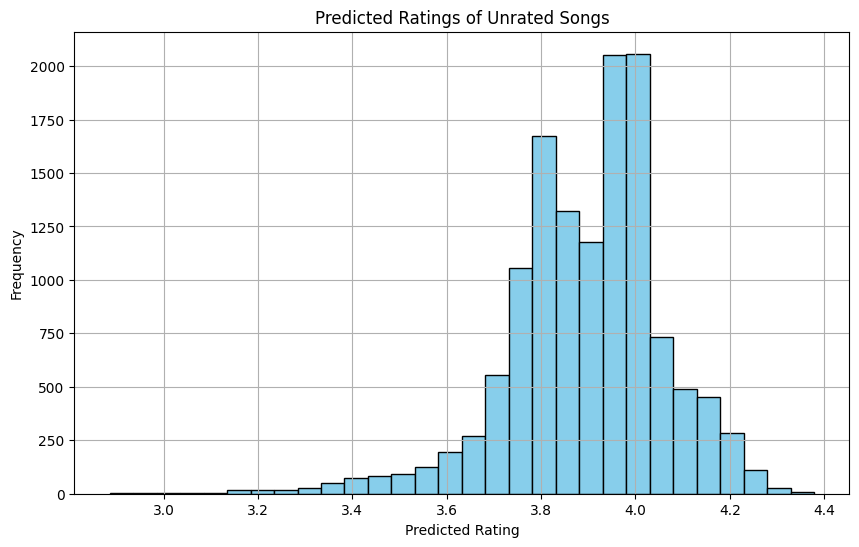

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()